# Spark
## K-means clustering
### Consulting project

In [17]:
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd

import findspark

from pyspark import SparkConf
from pyspark import SparkContext

from pyspark.sql import SparkSession
import pyspark.sql.functions as F

from pyspark.ml import Pipeline

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler

from pyspark.ml.clustering import  KMeans

from pyspark.ml.evaluation import ClusteringEvaluator

from matplotlib import pyplot as plt
import seaborn as sns

import optuna

In [2]:
findspark.init()
findspark.find()

%matplotlib inline
sns.set_theme(style='darkgrid')
sns.set_context("notebook", rc={"lines.linewidth": 2.5})

In [3]:
random_seed = 1

In [4]:
conf = SparkConf() \
    .setAppName("cluster-k-means") \
    #.setMaster('local') \
    #.set('spark.executor.memory', '8g') \
    #.set('spark.driver.maxResultSize', '8g') \
    #.set("spark.memory.fraction", "0.6") \
    #.set("spark.memory.storageFraction", "0.5") \
    #.set("spark.sql.shuffle.partitions", "5") \
    #.set("spark.memory.offHeap.enabled", "false") \
    #.set("spark.reducer.maxSizeInFlight", "96m") \
    #.set("spark.shuffle.file.buffer", "256k") \
    #.set("spark.sql.debug.maxToStringFields", "100") \
    #.set('spark.sql.autoBroadcastJoinThreshold', '-1')

In [5]:
%%capture

spark = SparkSession.builder.config(conf=conf).getOrCreate()

your 131072x1 screen size is bogus. expect trouble
23/11/08 15:58:32 WARN Utils: Your hostname, Diego-desktop resolves to a loopback address: 127.0.1.1; using 172.27.76.109 instead (on interface eth0)
23/11/08 15:58:32 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/11/08 15:58:37 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/11/08 15:58:42 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [6]:
df = spark.read.csv('../data/seeds_dataset.csv', header=True, inferSchema=True)

In [7]:
df.printSchema()

root
 |-- area: double (nullable = true)
 |-- perimeter: double (nullable = true)
 |-- compactness: double (nullable = true)
 |-- length_of_kernel: double (nullable = true)
 |-- width_of_kernel: double (nullable = true)
 |-- asymmetry_coefficient: double (nullable = true)
 |-- length_of_groove: double (nullable = true)



In [16]:
df.show(5)

+-----+---------+-----------+------------------+------------------+---------------------+----------------+
| area|perimeter|compactness|  length_of_kernel|   width_of_kernel|asymmetry_coefficient|length_of_groove|
+-----+---------+-----------+------------------+------------------+---------------------+----------------+
|15.26|    14.84|      0.871|             5.763|             3.312|                2.221|            5.22|
|14.88|    14.57|     0.8811| 5.553999999999999|             3.333|                1.018|           4.956|
|14.29|    14.09|      0.905|             5.291|3.3369999999999997|                2.699|           4.825|
|13.84|    13.94|     0.8955|             5.324|3.3789999999999996|                2.259|           4.805|
|16.14|    14.99|     0.9034|5.6579999999999995|             3.562|                1.355|           5.175|
+-----+---------+-----------+------------------+------------------+---------------------+----------------+
only showing top 5 rows



In [11]:
df.head(1)[0].asDict()

{'area': 15.26,
 'perimeter': 14.84,
 'compactness': 0.871,
 'length_of_kernel': 5.763,
 'width_of_kernel': 3.312,
 'asymmetry_coefficient': 2.221,
 'length_of_groove': 5.22}

In [9]:
df.columns

['area',
 'perimeter',
 'compactness',
 'length_of_kernel',
 'width_of_kernel',
 'asymmetry_coefficient',
 'length_of_groove']

In [13]:
VectorAssembler?

Init signature:
VectorAssembler(
    *,
    inputCols: Optional[List[str]] = None,
    outputCol: Optional[str] = None,
    handleInvalid: str = 'error',
)
Docstring:     
A feature transformer that merges multiple columns into a vector column.

.. versionadded:: 1.4.0

Examples
--------
>>> df = spark.createDataFrame([(1, 0, 3)], ["a", "b", "c"])
>>> vecAssembler = VectorAssembler(outputCol="features")
>>> vecAssembler.setInputCols(["a", "b", "c"])
VectorAssembler...
>>> vecAssembler.transform(df).head().features
DenseVector([1.0, 0.0, 3.0])
>>> vecAssembler.setParams(outputCol="freqs").transform(df).head().freqs
DenseVector([1.0, 0.0, 3.0])
>>> params = {vecAssembler.inputCols: ["b", "a"], vecAssembler.outputCol: "vector"}
>>> vecAssembler.transform(df, params).head().vector
DenseVector([0.0, 1.0])
>>> vectorAssemblerPath = temp_path + "/vector-assembler"
>>> vecAssembler.save(vectorAssemblerPath)
>>> loadedAssembler = VectorAssembler.load(vectorAssemblerPath)
>>> loadedAssembler.tra

In [14]:
assembler = VectorAssembler(
    inputCols=df.columns,
    outputCol='features'
)

data_input = assembler.transform(df)

In [15]:
data_input.show(5)

+-----+---------+-----------+------------------+------------------+---------------------+----------------+--------------------+
| area|perimeter|compactness|  length_of_kernel|   width_of_kernel|asymmetry_coefficient|length_of_groove|            features|
+-----+---------+-----------+------------------+------------------+---------------------+----------------+--------------------+
|15.26|    14.84|      0.871|             5.763|             3.312|                2.221|            5.22|[15.26,14.84,0.87...|
|14.88|    14.57|     0.8811| 5.553999999999999|             3.333|                1.018|           4.956|[14.88,14.57,0.88...|
|14.29|    14.09|      0.905|             5.291|3.3369999999999997|                2.699|           4.825|[14.29,14.09,0.90...|
|13.84|    13.94|     0.8955|             5.324|3.3789999999999996|                2.259|           4.805|[13.84,13.94,0.89...|
|16.14|    14.99|     0.9034|5.6579999999999995|             3.562|                1.355|           5.17

In [19]:
scaler = StandardScaler(
    inputCol='features',
    outputCol='scaled_features'
)

data_input = scaler.fit(data_input).transform(data_input)

In [20]:
data_input.show(5)

+-----+---------+-----------+------------------+------------------+---------------------+----------------+--------------------+--------------------+
| area|perimeter|compactness|  length_of_kernel|   width_of_kernel|asymmetry_coefficient|length_of_groove|            features|     scaled_features|
+-----+---------+-----------+------------------+------------------+---------------------+----------------+--------------------+--------------------+
|15.26|    14.84|      0.871|             5.763|             3.312|                2.221|            5.22|[15.26,14.84,0.87...|[5.24452795332028...|
|14.88|    14.57|     0.8811| 5.553999999999999|             3.333|                1.018|           4.956|[14.88,14.57,0.88...|[5.11393027165175...|
|14.29|    14.09|      0.905|             5.291|3.3369999999999997|                2.699|           4.825|[14.29,14.09,0.90...|[4.91116018695588...|
|13.84|    13.94|     0.8955|             5.324|3.3789999999999996|                2.259|           4.805|

In [43]:
kmeans = KMeans(
    seed=random_seed,
    featuresCol = 'features',
    k=3,
)

In [44]:
model = kmeans.fit(data_input)

In [45]:
pred = model.transform(data_input)

In [46]:
ClusteringEvaluator?

Init signature:
ClusteringEvaluator(
    *,
    predictionCol: str = 'prediction',
    featuresCol: str = 'features',
    metricName: 'ClusteringEvaluatorMetricType' = 'silhouette',
    distanceMeasure: str = 'squaredEuclidean',
    weightCol: Optional[str] = None,
)
Docstring:     
Evaluator for Clustering results, which expects two input
columns: prediction and features. The metric computes the Silhouette
measure using the squared Euclidean distance.

The Silhouette is a measure for the validation of the consistency
within clusters. It ranges between 1 and -1, where a value close to
1 means that the points in a cluster are close to the other points
in the same cluster and far from the points of the other clusters.

.. versionadded:: 2.3.0

Examples
--------
>>> from pyspark.ml.linalg import Vectors
>>> featureAndPredictions = map(lambda x: (Vectors.dense(x[0]), x[1]),
...     [([0.0, 0.5], 0.0), ([0.5, 0.0], 0.0), ([10.0, 11.0], 1.0),
...     ([10.5, 11.5], 1.0), ([1.0, 1.0], 0.0), (

In [47]:
wssse = model.summary.trainingCost
wssse

0.07499999999994544

In [48]:
model.clusterCenters()

[array([9.1, 9.1, 9.1]), array([0.05, 0.05, 0.05]), array([0.2, 0.2, 0.2])]

In [49]:
results = model.transform(data_input)
results.show()

+--------------------+----------+
|            features|prediction|
+--------------------+----------+
|           (3,[],[])|         1|
|(3,[0,1,2],[0.1,0...|         1|
|(3,[0,1,2],[0.2,0...|         2|
|(3,[0,1,2],[9.0,9...|         0|
|(3,[0,1,2],[9.1,9...|         0|
|(3,[0,1,2],[9.2,9...|         0|
+--------------------+----------+



In [21]:
k_list = [_ for _ in range(2, 15)]
wsssse_list = []

for k in k_list:
    
    kmeans = KMeans(
    seed=random_seed,
    featuresCol = 'scaled_features',
    k=k,
    )
    
    model = kmeans.fit(data_input)
    
    wssse = model.summary.trainingCost
    wsssse_list.append(wssse)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


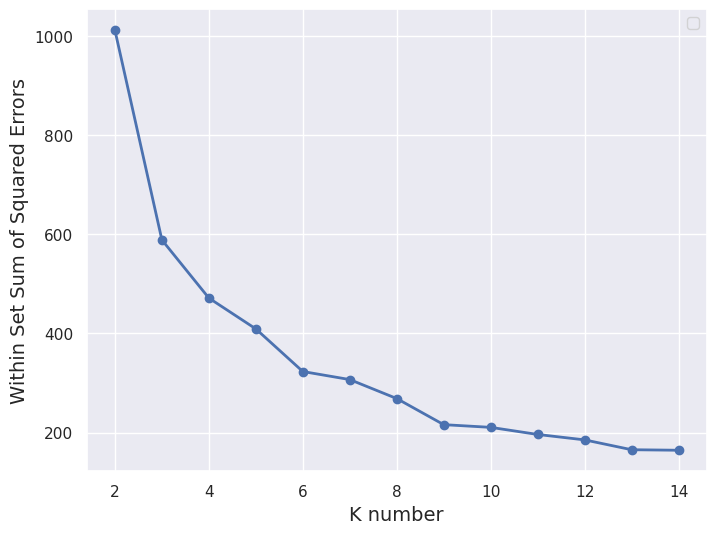

In [23]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(k_list, wsssse_list, '-o', linewidth=2)


ax.set_ylabel('Within Set Sum of Squared Errors', size=14)
ax.set_xlabel('K number', size=14)

plt.legend()
plt.show()

In [24]:
best_k = 5

kmeans = KMeans(
seed=random_seed,
featuresCol = 'scaled_features',
k=best_k,
)

model = kmeans.fit(data_input)

In [25]:
model.clusterCenters()

[array([ 4.078007  , 10.15076404, 35.87686106, 11.81860981,  7.5430707 ,
         3.17727834, 10.39174095]),
 array([ 6.72560877, 12.76763167, 37.42009443, 14.34320435, 10.11571056,
         3.10543191, 12.5881902 ]),
 array([ 4.88160387, 10.87553512, 37.39498449, 12.30974854,  8.58187989,
         1.62825894, 10.27141465]),
 array([ 6.38139492, 12.4098598 , 37.58226767, 13.93439956,  9.81958739,
         1.79806715, 12.29406686]),
 array([ 5.50668562, 11.62517597, 36.9442892 , 13.17725404,  9.00214447,
         2.81106367, 11.47610131])]

In [28]:
predictions = model.transform(data_input)

In [29]:
predictions.show(6)

+-----+---------+-----------+------------------+------------------+---------------------+----------------+--------------------+--------------------+----------+
| area|perimeter|compactness|  length_of_kernel|   width_of_kernel|asymmetry_coefficient|length_of_groove|            features|     scaled_features|prediction|
+-----+---------+-----------+------------------+------------------+---------------------+----------------+--------------------+--------------------+----------+
|15.26|    14.84|      0.871|             5.763|             3.312|                2.221|            5.22|[15.26,14.84,0.87...|[5.24452795332028...|         2|
|14.88|    14.57|     0.8811| 5.553999999999999|             3.333|                1.018|           4.956|[14.88,14.57,0.88...|[5.11393027165175...|         2|
|14.29|    14.09|      0.905|             5.291|3.3369999999999997|                2.699|           4.825|[14.29,14.09,0.90...|[4.91116018695588...|         2|
|13.84|    13.94|     0.8955|           